🔹 Features numériques (7): ['hour', 'day_of_week', 'action_code', 'actions_per_session', 'session_duration_sec', 'time_diff_sec', 'is_private_ip']
🔹 Features catégoriques (7): ['action', 'ip_address', 'user_agent', 'device_type', 'browser_family', 'os_family', 'bot_type']

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       172

    accuracy                           1.00       401
   macro avg       1.00      1.00      1.00       401
weighted avg       1.00      1.00      1.00       401



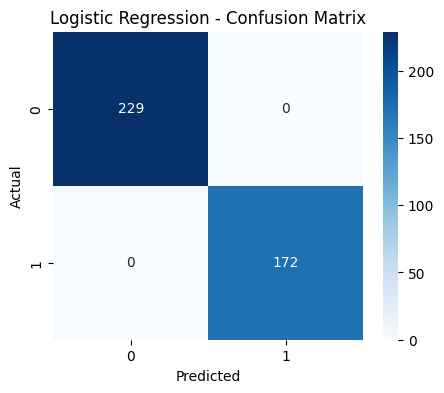


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       229
           1       0.99      1.00      0.99       172

    accuracy                           1.00       401
   macro avg       0.99      1.00      0.99       401
weighted avg       1.00      1.00      1.00       401



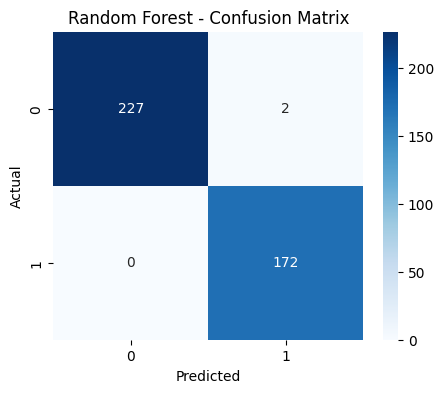

/tmp/ipython-input-1177337335.py:114: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


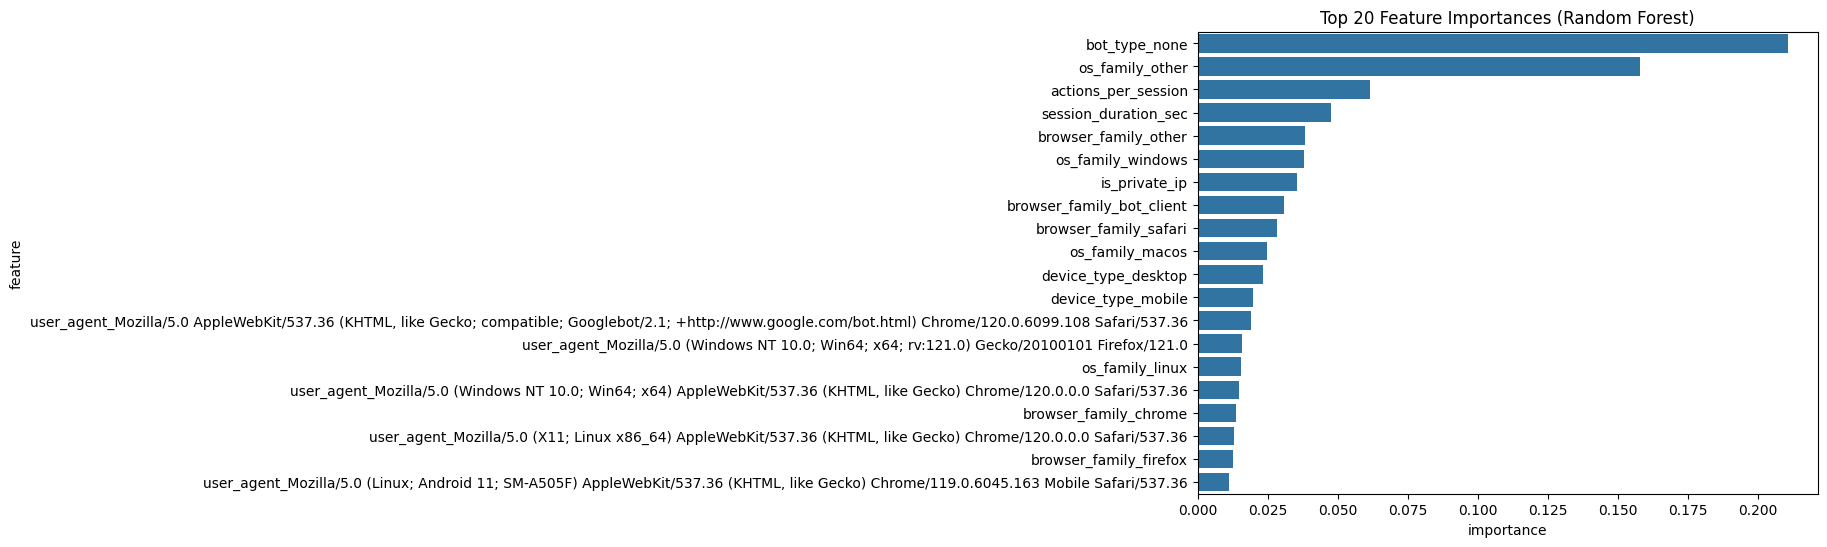


=== Résumé des performances ===

Logistic Regression:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000
  roc_auc: 1.0000

Random Forest:
  accuracy: 0.9950
  precision: 0.9885
  recall: 1.0000
  f1_score: 0.9942
  roc_auc: 1.0000


In [ ]:
# ================================
# Modeling: Bot Detection
# ================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1️⃣ Chargement du dataset
# ------------------------------
df = pd.read_csv("/content/dataset_features_complete.csv")

# ------------------------------
# 2️⃣ Sélection des features et target
# ------------------------------
target = 'is_bot'

# Features à utiliser (tout sauf event_id, session_id, timestamp, event_time, target)
drop_cols = ['event_id', 'session_id', 'timestamp', 'event_time', target]
X = df.drop(columns=drop_cols)
y = df[target]

# Séparer features numériques et catégoriques
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'string']).columns.tolist()

print(f"🔹 Features numériques ({len(num_features)}): {num_features}")
print(f"🔹 Features catégoriques ({len(cat_features)}): {cat_features}")

# ------------------------------
# 3️⃣ Split train/test stratifié
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 4️⃣ Préprocessing pipeline
# ------------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# ------------------------------
# 5️⃣ Modèles à tester
# ------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# ------------------------------
# 6️⃣ Entraînement et évaluation
# ------------------------------
results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': roc
    }

    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature importance pour Random Forest
    if name == "Random Forest":
        # Extraire le préprocesseur pour encoder features
        feature_names_num = num_features
        feature_names_cat = pipe.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
        feature_names = np.concatenate([feature_names_num, feature_names_cat])
        importances = model.feature_importances_
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values(by='importance', ascending=False).head(20)

        plt.figure(figsize=(8,6))
        sns.barplot(x='importance', y='feature', data=fi_df)
        plt.title("Top 20 Feature Importances (Random Forest)")
        plt.tight_layout()
        plt.show()

# ------------------------------
# 7️⃣ Résumé des performances
# ------------------------------
print("\n=== Résumé des performances ===")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# ====== Cross-validation ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    print(f"=== {name} ===")
    print(f"Cross-validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}\n")

=== Logistic Regression ===
Cross-validation Accuracy: 1.0000 ± 0.0000

=== Random Forest ===
Cross-validation Accuracy: 0.9965 ± 0.0020



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Dataset
X_cat = df[['action', 'ip_address', 'user_agent', 'device_type', 'browser_family', 'os_family', 'bot_type']]
y = df['is_bot']

# Encoder les features catégoriques pour calculer corrélation
X_enc = X_cat.apply(LabelEncoder().fit_transform)

# Corrélation avec la cible
corr_with_target = X_enc.corrwith(y)
print("Corrélation des features catégoriques avec la cible:\n", corr_with_target.sort_values(ascending=False))


Corrélation des features catégoriques avec la cible:
 user_agent        0.419127
os_family         0.310506
ip_address        0.152852
bot_type          0.009448
action           -0.014734
browser_family   -0.173396
device_type      -0.431354
dtype: float64


In [ ]:
# Librairies
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ==== Préparation des données ====
# Suppose que ton DataFrame s'appelle df et la cible 'is_bot'
target = 'is_bot'

# Features catégoriques à tester
categorical_features = ['action', 'ip_address', 'user_agent', 'device_type', 'browser_family', 'os_family', 'bot_type']
numeric_features = ['hour', 'day_of_week', 'action_code', 'actions_per_session', 'session_duration_sec', 'time_diff_sec', 'is_private_ip']

# On retire les features fortement corrélées
high_corr_features = ['device_type', 'user_agent', 'os_family']
categorical_features_reduced = [f for f in categorical_features if f not in high_corr_features]

# Split train/test
X = df[numeric_features + categorical_features]
y = df[target]

X_reduced = df[numeric_features + categorical_features_reduced]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# ==== Préprocessing ====
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features_reduced)
    ])

# ==== Modèles ====
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# ==== Fonction pour cross-validation ====
def evaluate_model(model, X, y):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    return scores.mean(), scores.std()

def evaluate_model_reduced(model, X, y):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_reduced), ('classifier', model)])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    return scores.mean(), scores.std()

# ==== Évaluation ====
print("=== Modèles avec toutes les features ===")
for name, model in models.items():
    mean_acc, std_acc = evaluate_model(model, X_train, y_train)
    print(f"{name}: Accuracy CV = {mean_acc:.4f} ± {std_acc:.4f}")

print("\n=== Modèles sans features fortement corrélées ===")
for name, model in models.items():
    mean_acc, std_acc = evaluate_model_reduced(model, Xr_train, yr_train)
    print(f"{name}: Accuracy CV = {mean_acc:.4f} ± {std_acc:.4f}")


=== Modèles avec toutes les features ===
Logistic Regression: Accuracy CV = 1.0000 ± 0.0000
Random Forest: Accuracy CV = 0.9956 ± 0.0047

=== Modèles sans features fortement corrélées ===
Logistic Regression: Accuracy CV = 1.0000 ± 0.0000
Random Forest: Accuracy CV = 1.0000 ± 0.0000


In [ ]:
# ==================================================
# Notebook complet MLOps - Classification Bot/Humain
# ==================================================

# 1️⃣ Import des librairies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# 2️⃣ Chargement des données
# Remplace 'data.csv' par ton fichier
df = pd.read_csv('/content/dataset_features_complete.csv')

# Séparation features / target
target = 'is_bot'
num_features = ['hour', 'day_of_week', 'action_code', 'actions_per_session', 'session_duration_sec', 'time_diff_sec', 'is_private_ip']
cat_features = ['action', 'ip_address', 'user_agent', 'device_type', 'browser_family', 'os_family', 'bot_type']

X = df[num_features + cat_features]
y = df[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3️⃣ Préprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# 4️⃣ Test de plusieurs modèles pour baseline
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# 5️⃣ Entraînement du final model (RandomForest recommandé)
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))])
final_model.fit(X_train, y_train)

# 6️⃣ Évaluation sur test set
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:,1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("ROC-AUC (Test Set):", roc_auc_score(y_test, y_prob))

# 7️⃣ Cross-validation finale
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print("\nFinal Model Accuracy CV:", cv_scores.mean(), "±", cv_scores.std())

# 8️⃣ Export du pipeline MLOps
joblib.dump(final_model, "pipeline_mlops.pkl")
print("\n✅ Pipeline sauvegardé : pipeline_mlops.pkl")


LogisticRegression CV Accuracy: 1.0000 ± 0.0000
RandomForest CV Accuracy: 0.9956 ± 0.0047
GradientBoosting CV Accuracy: 1.0000 ± 0.0000

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       229
           1       0.99      1.00      0.99       172

    accuracy                           1.00       401
   macro avg       0.99      1.00      0.99       401
weighted avg       1.00      1.00      1.00       401

ROC-AUC (Test Set): 1.0

Final Model Accuracy CV: 0.9995012468827931 ± 0.0009975062344139475

✅ Pipeline sauvegardé : pipeline_mlops.pkl


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       229
           1       0.98      1.00      0.99       172

    accuracy                           0.99       401
   macro avg       0.99      0.99      0.99       401
weighted avg       0.99      0.99      0.99       401

ROC-AUC (Test Set): 1.0000


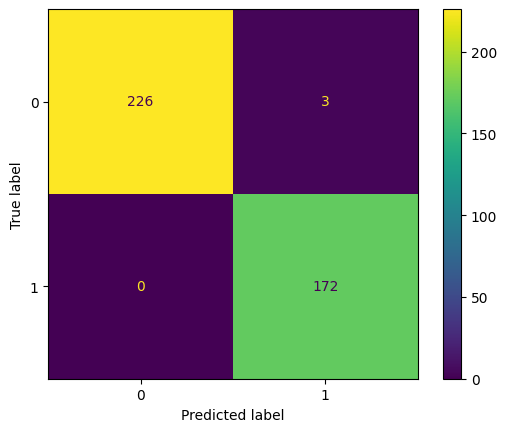

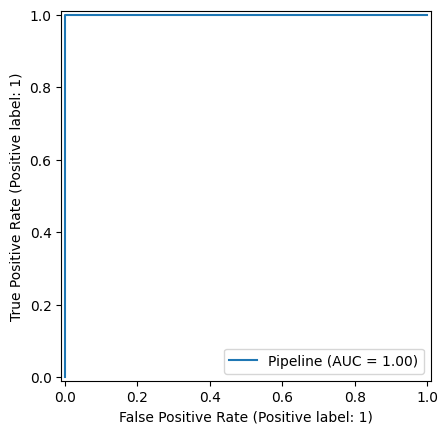

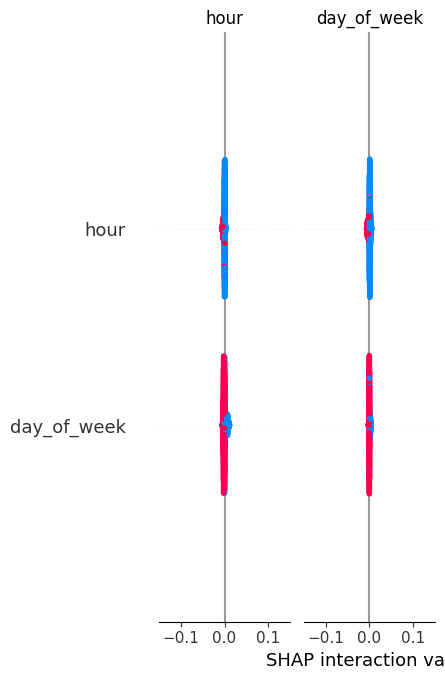

✅ Pipeline sauvegardé : pipeline_mlops_enriched.pkl


In [ ]:
# =========================================
# Notebook MLOps Complet : Enrichissement + Pipeline + Evaluation
# =========================================

# 🔹 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import shap
import joblib

# =========================================
# 🔹 2. Charger le dataset
df = pd.read_csv("/content/dataset_features_complete.csv")  # Adapter ton chemin/fichier

# =========================================
# 🔹 3. Enrichissement du dataset

# Feature temporelles
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >=6 else 0)

# Feature comportementales
df['avg_time_per_action'] = df['session_duration_sec'] / (df['actions_per_session'] + 1e-6)
df['rapid_action_flag'] = (df['time_diff_sec'] < 0.1).astype(int)

# =========================================
# 🔹 4. Features & Target
numeric_features = ['hour', 'day_of_week', 'action_code', 'actions_per_session',
                    'session_duration_sec', 'time_diff_sec', 'is_private_ip',
                    'hour_sin','hour_cos','avg_time_per_action','rapid_action_flag']

categorical_features = ['action', 'ip_address', 'user_agent', 'device_type',
                        'browser_family', 'os_family', 'bot_type']

target = 'is_bot'

X = df[numeric_features + categorical_features]
y = df[target]

# =========================================
# 🔹 5. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================================
# 🔹 6. Preprocessing Pipeline
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # <- dense array pour SHAP
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# =========================================
# 🔹 7. Modèle final et Pipeline
final_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

# =========================================
# 🔹 8. Entraînement
pipeline.fit(X_train, y_train)

# =========================================
# 🔹 9. Evaluation
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC (Test Set): {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

# =========================================
# 🔹 10. Importance des features avec SHAP

# Extraire noms des features après transformation
feature_names = numeric_features + list(
    pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(categorical_features)
)

# Explainer SHAP
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])

# Transformer X_train
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

# Calcul SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

# =========================================
# 🔹 11. Sauvegarde du pipeline
joblib.dump(pipeline, "pipeline_mlops_enriched.pkl")
print("✅ Pipeline sauvegardé : pipeline_mlops_enriched.pkl")


In [ ]:
# =========================================
# Notebook MLOps Complet : Modelling + Evaluation + SHAP
# =========================================

# 🔹 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import shap
import joblib

# =========================================
# 🔹 2. Charger le dataset
df = pd.read_csv("/content/dataset_features_complete.csv")

# =========================================
# 🔹 3. Feature Engineering

# Feature temporelles
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >=6 else 0)

# Feature comportementales
df['avg_time_per_action'] = df['session_duration_sec'] / (df['actions_per_session'] + 1e-6)
df['rapid_action_flag'] = (df['time_diff_sec'] < 0.1).astype(int)

# =========================================
# 🔹 4. Features & Target
numeric_features = ['hour', 'day_of_week', 'action_code', 'actions_per_session',
                    'session_duration_sec', 'time_diff_sec', 'is_private_ip',
                    'hour_sin','hour_cos','avg_time_per_action','rapid_action_flag']

categorical_features = ['action', 'ip_address', 'user_agent', 'device_type',
                        'browser_family', 'os_family', 'bot_type']

target = 'is_bot'

X = df[numeric_features + categorical_features]
y = df[target]

# =========================================
# 🔹 5. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================================
# 🔹 6. Preprocessing Pipeline
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # <- important pour SHAP
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# =========================================
# 🔹 7. Modèles baseline
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42)
}

for name, model in models.items():
    pipeline_tmp = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline_tmp, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

# =========================================
# 🔹 8. Final Model Pipeline
final_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

pipeline.fit(X_train, y_train)

# =========================================
# 🔹 9. Evaluation Test Set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC (Test Set): {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

# =========================================
# 🔹 10. SHAP Importance (corrigé)
# Transformer les données en float
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_train_transformed = np.array(X_train_transformed, dtype=float)

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed,
                  feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out())

# =========================================
# 🔹 11. Export Pipeline MLOps
joblib.dump(pipeline, "pipeline_mlops_final.pkl")
print("✅ Pipeline sauvegardé : pipeline_mlops_final.pkl")


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'